<h1>Load yours data</h1>

In [1]:
# -- Import --
import pandas as pd
import ta
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import clear_output
from math import *
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import sys
import ccxt
sys.path.append( '../../utilities' )
from data_engine import DataEngine

# -- You can change the crypto pair ,the start date and the time interval below --
pair = 'SOL/USDT'
timeframe = '1h'
startDate = '2017-01-01T00:00:00'

dataEngine = DataEngine(session=ccxt.binance(), path_to_data='../database/')

df = dataEngine.get_historical_from_db(pair, timeframe, startDate)

print("Data loaded 100%")

# -- Uncomment the line below if you want to check your price dataset --
# df

Successfully load 13604 candles for SOLUSDT
Data loaded 100%


<h1>Define your indicators</h1>

In [6]:
# -- Indicator variable --
trixLength = 8
trixSignal = 18
stochWindow = 14

# -- Drop all columns we do not need --
df.drop(columns=df.columns.difference(['open','high','low','close','volume']), inplace=True)

# -- Indicators, you can edit every value --
df['TRIX'] = ta.trend.ema_indicator(ta.trend.ema_indicator(ta.trend.ema_indicator(close=df['close'], window=trixLength), window=trixLength), window=trixLength)
df['TRIX_PCT'] = df["TRIX"].pct_change()*100
df['TRIX_SIGNAL'] = ta.trend.sma_indicator(df['TRIX_PCT'], trixSignal)
df['TRIX_HISTO'] = df['TRIX_PCT'] - df['TRIX_SIGNAL']
df['STOCH_RSI'] = ta.momentum.stochrsi(close=df['close'], window=14, smooth1=3, smooth2=3)


print("Indicators loaded 100%")
df

Indicators loaded 100%


,open,high,low,close,volume,TRIX,TRIX_PCT,TRIX_SIGNAL,TRIX_HISTO,STOCH_RSI
timestamp,,,,,,,,,,
2020-08-11 06:00:00,2.8500,3.4700,2.8500,2.9515,20032.26,NaN,NaN,NaN,NaN,NaN
2020-08-11 07:00:00,2.9515,3.1355,2.8800,2.9224,42069.37,NaN,NaN,NaN,NaN,NaN
2020-08-11 08:00:00,2.9626,3.0000,2.9144,2.9600,24280.76,NaN,NaN,NaN,NaN,NaN
2020-08-11 09:00:00,2.9600,2.9736,2.8500,2.8543,26371.23,NaN,NaN,NaN,NaN,NaN
2020-08-11 10:00:00,2.8566,2.9329,2.8433,2.8976,26685.94,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
2022-03-01 15:00:00,98.0900,99.1400,96.6700,97.8700,202435.93,97.131242,0.152662,0.336762,-0.184100,0.144395
2022-03-01 16:00:00,97.8700,98.6900,96.0200,96.5400,139934.36,97.252773,0.125120,0.305374,-0.180254,0.000000
2022-03-01 17:00:00,96.5500,98.0400,96.3700,97.5100,90218.32,97.349309,0.099263,0.272399,-0.173136,0.174826


<h1>Overbought optimizer</h1>

Loading... 42 / 42


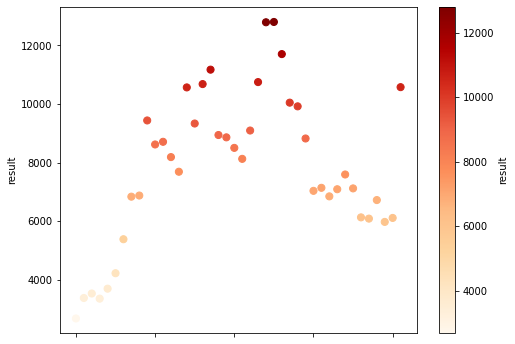

    param1        result
0     60.0   2675.121895
3     63.0   3352.741818
1     61.0   3374.996931
2     62.0   3527.863511
4     64.0   3692.827714
5     65.0   4221.204828
6     66.0   5381.828339
39    99.0   5973.050542
37    97.0   6085.734208
40   100.0   6108.742445
36    96.0   6128.230930
38    98.0   6719.403394
7     67.0   6835.173831
32    92.0   6845.579383
8     68.0   6873.827332
30    90.0   7034.194065
33    93.0   7089.305111
35    95.0   7117.703164
31    91.0   7137.537597
34    94.0   7592.751672
13    73.0   7686.693028
21    81.0   8126.530748
12    72.0   8186.933043
20    80.0   8501.481979
10    70.0   8617.988012
11    71.0   8708.798139
29    89.0   8822.231444
19    79.0   8861.349684
18    78.0   8940.723469
22    82.0   9094.331520
15    75.0   9333.550507
9     69.0   9438.176575
28    88.0   9920.103295
27    87.0  10046.015166
14    74.0  10566.584315
41   101.0  10575.671584
16    76.0  10680.552622
23    83.0  10748.747550
17    77.0  11172.843683


In [3]:
dfTest = None
dt = None
dt = pd.DataFrame(columns = ['param1', 'result'])

# dfTest = df.copy()

# -- If you want to run your BackTest on a specific period, uncomment the line below --
dfTest = df[:]

# -- Condition to BUY market --
def buyCondition(row, stochOverBought):
  if row['TRIX_HISTO'] >= 0 and row['STOCH_RSI'] < stochOverBought:
    return True
  else:
    return False

# -- Condition to SELL market --  
def sellCondition(row):
  if row['TRIX_HISTO'] < 0:
        return True
  else:
        return False

loopI = [60, 102, 1]
enumI = ceil((loopI[1] - loopI[0]) / loopI[2])

count = 0
maxCount = enumI
for i in range(loopI[0], loopI[1], loopI[2]):
  count += 1
  clear_output(wait=True)
  print("Loading...",count,'/',maxCount)
  # -- You can change variables below --
  usdt = 1000
  coin = 0

  stochTop = i / 100

  previousRow = dfTest.iloc[0]

  for index, row in dfTest.iterrows():
    #BUY
    if buyCondition(row, stochTop) and usdt > 0:
      coin = (usdt/row['close']) - 0.0007 * (usdt/row['close'])
      usdt = 0

    #SELL
    elif sellCondition(row) and coin > 0:
      usdt = coin * row['close'] - (0.0007 * coin * row['close'])
      coin = 0

  myrow = {'param1': i,'result': coin * dfTest.iloc[len(dfTest)-1]['close'] + usdt}
  dt = dt.append(myrow,ignore_index=True)   

dt.plot.scatter(x='param1',y=1,c='result',s=50,colormap='OrRd',figsize=(8,6))

plt.show()

print(dt.sort_values(by=['result']))

<h2>Trix Parameters Optimizer</h2>

Loading... 260 / 260


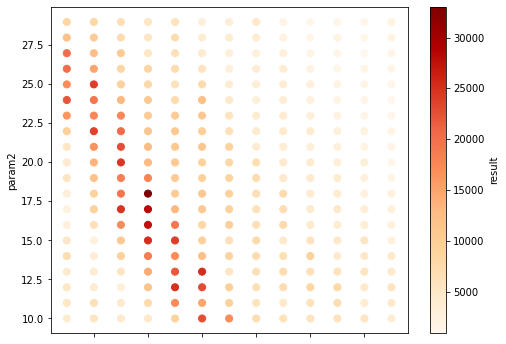

     param1  param2        result
237    16.0    27.0    889.934541
254    17.0    24.0    990.918159
238    16.0    28.0   1164.916060
216    15.0    26.0   1175.515208
199    14.0    29.0   1182.088681
..      ...     ...           ...
103    10.0    13.0  25171.200952
65      8.0    15.0  25199.282698
66      8.0    16.0  27577.067265
67      8.0    17.0  28166.842781
68      8.0    18.0  32991.663701

[260 rows x 3 columns]


In [4]:
dfTest = None
dt = None
dt = pd.DataFrame(columns = ['param1','param2', 'result'])

# dfTest = df.copy()

# -- If you want to run your BackTest on a specific period, uncomment the line below --
dfTest = df[:]

# -- Condition to BUY market --
def buyCondition(row, stochOverBought):
  if row['TRIX_HISTO'] >= 0 and row['STOCH_RSI'] < stochOverBought:
    return True
  else:
    return False

# -- Condition to SELL market --  
def sellCondition(row):
  if row['TRIX_HISTO'] < 0:
        return True
  else:
        return False

loopI = [5, 18, 1]
enumI = ceil((loopI[1] - loopI[0]) / loopI[2])

loopJ = [10, 30, 1]
enumJ = ceil((loopJ[1] - loopJ[0]) / loopJ[2])

count = 0
maxCount = enumI * enumJ
for i in range(loopI[0], loopI[1], loopI[2]):
  for j in range(loopJ[0], loopJ[1], loopJ[2]):
    count += 1
    clear_output(wait=True)
    print("Loading...",count,'/',maxCount)
    # -- You can change variables below --
    usdt = 1000
    coin = 0

    trixLength = i
    trixSignal = j
    # -- Indicators, you can edit every value --
    dfTest['TRIX'] = ta.trend.ema_indicator(ta.trend.ema_indicator(ta.trend.ema_indicator(close=dfTest['close'], window=trixLength), window=trixLength), window=trixLength)
    dfTest['TRIX_PCT'] = dfTest["TRIX"].pct_change()*100
    dfTest['TRIX_SIGNAL'] = ta.trend.sma_indicator(dfTest['TRIX_PCT'], trixSignal)
    dfTest['TRIX_HISTO'] = dfTest['TRIX_PCT'] - dfTest['TRIX_SIGNAL']

    stochTop = 0.85

    previousRow = dfTest.iloc[0]

    for index, row in dfTest.iterrows():
      #BUY
      if buyCondition(row, stochTop) and usdt > 0:
        coin = (usdt/row['close']) - 0.0007 * (usdt/row['close'])
        usdt = 0

      #SELL
      elif sellCondition(row) and coin > 0:
        usdt = coin * row['close'] - (0.0007 * coin * row['close'])
        coin = 0

    myrow = {'param1': i, 'param2': j,'result': coin * dfTest.iloc[len(dfTest)-1]['close'] + usdt}
    dt = dt.append(myrow,ignore_index=True)   

dt.plot.scatter(x='param1',y='param2',c='result',s=50,colormap='OrRd',figsize=(8,6))
plt.show()

print(dt.sort_values(by=['result']))

<h1>Stock RSI Optimizer</h1>

Loading... 29 / 29


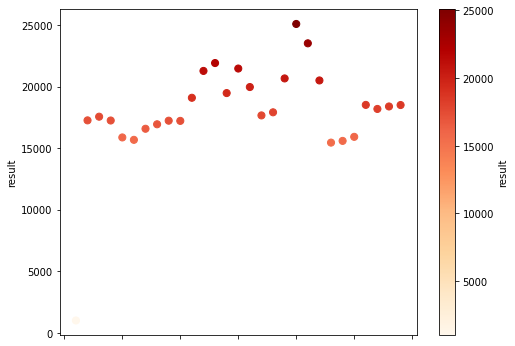

    param1        result
0      1.0   1000.000000
22    23.0  15454.159931
23    24.0  15593.163733
5      6.0  15678.938662
4      5.0  15874.513193
24    25.0  15922.784696
6      7.0  16579.746767
7      8.0  16944.071086
9     10.0  17219.846439
8      9.0  17235.027561
3      4.0  17250.499381
1      2.0  17262.140071
2      3.0  17560.711074
16    17.0  17664.599095
17    18.0  17916.788752
26    27.0  18189.788226
27    28.0  18391.511371
28    29.0  18507.874945
25    26.0  18518.611472
10    11.0  19096.803818
13    14.0  19479.795816
15    16.0  19970.274823
21    22.0  20506.080571
18    19.0  20669.687044
11    12.0  21279.551712
14    15.0  21473.462015
12    13.0  21919.924282
20    21.0  23522.742445
19    20.0  25095.636255


In [7]:
dfTest = None
dt = None
dt = pd.DataFrame(columns = ['param1', 'result'])

# dfTest = df.copy()

# -- If you want to run your BackTest on a specific period, uncomment the line below --
dfTest = df[:]

# -- Condition to BUY market --
def buyCondition(row, stochOverBought):
  if row['TRIX_HISTO'] >= 0 and row['STOCH_RSI'] < stochOverBought:
    return True
  else:
    return False

# -- Condition to SELL market --  
def sellCondition(row):
  if row['TRIX_HISTO'] < 0:
        return True
  else:
        return False

loopI = [1, 30, 1]
enumI = ceil((loopI[1] - loopI[0]) / loopI[2])

count = 0
maxCount = enumI
for i in range(loopI[0], loopI[1], loopI[2]):
    count += 1
    clear_output(wait=True)
    print("Loading...",count,'/',maxCount)
    # -- You can change variables below --
    usdt = 1000
    coin = 0

    dfTest['STOCH_RSI'] = ta.momentum.stochrsi(close=dfTest['close'], window=i, smooth1=3, smooth2=3)

    stochTop = 0.90

    previousRow = dfTest.iloc[0]

    for index, row in dfTest.iterrows():
      #BUY
      if buyCondition(row, stochTop) and usdt > 0:
        coin = (usdt/row['close']) - 0.0007 * (usdt/row['close'])
        usdt = 0

      #SELL
      elif sellCondition(row) and coin > 0:
        usdt = coin * row['close'] - (0.0007 * coin * row['close'])
        coin = 0

    myrow = {'param1': i,'result': coin * dfTest.iloc[len(dfTest)-1]['close'] + usdt}
    dt = dt.append(myrow,ignore_index=True)   

dt.plot.scatter(x='param1',y=1,c='result',s=50,colormap='OrRd',figsize=(8,6))

plt.show()

print(dt.sort_values(by=['result']))